# MUTATION DETECTION CHALLENGE

### 0. Libraries


In [1]:
from pathlib import Path 
import sys
import warnings
from copy import deepcopy
import multiprocessing

import numpy as np
import pandas as pd 
import torch
import torch.nn as nn

from datetime import datetime
from IPython.display import clear_output

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [ ]:
# The path can also be read from a config file, etc.
# OPENSLIDE_PATH = r"C:\Users\Sébastien Mandela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openslide-win64-20230414\openslide-win64-20230414\bin"
# print(OPENSLIDE_PATH)
# import os
# if hasattr(os, 'add_dll_directory'):
#     # Windows
#     with os.add_dll_directory(OPENSLIDE_PATH):
#         import openslide
# else:
#     import openslide

In [2]:
np.random.seed(42)
torch.manual_seed(42)

working_directory = Path(".").resolve() #########
#sys.path.append(str(working_directory))
print(sys.path)

['/users/eleves-b/2021/sebastien.mandela-yvon/Desktop/mutation_detection', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/users/eleves-b/2021/sebastien.mandela-yvon/Desktop/mutation_detection/.venv/lib64/python3.9/site-packages', '/users/eleves-b/2021/sebastien.mandela-yvon/Desktop/mutation_detection/.venv/lib/python3.9/site-packages']


In [4]:
## try rerunning this cell in case of module import error
from utils.features import pad_collate_fn
from utils.functional import sigmoid, softmax
from datasets.core import SlideFeaturesDataset
from models.chowder import Chowder
from trainer import TorchTrainer
from trainer.utils import slide_level_train_step, slide_level_val_step

### 1. Data Loading

In [5]:

# 1. Load the precomputed features

## Train and test directories
train_features_dir = working_directory / "data" / "train_input" / "moco_features"
test_features_dir = working_directory / "data" / "test_input" / "moco_features"

## List of all the files in each directory
train_features_path_all = list(train_features_dir.glob("*.npy"))
test_features_path_all = list(test_features_dir.glob("*.npy"))

## 2. Load the metadata
train_metadata_df = pd.read_csv(working_directory / "data" / "supplementary_data" / "train_metadata.csv")
test_metadata_df = pd.read_csv(working_directory / "data" / "supplementary_data" / "test_metadata.csv")

## 3. Load the traning labels
y_train = pd.read_csv(working_directory / "data" / "train_output.csv")
## And concatenate the labels to the metadata
train_metadata_df = pd.merge(train_metadata_df, y_train, on="Sample ID")

y_train = train_metadata_df["Target"].values.astype(np.float32) ## float32 required for BCE loss

In [6]:
## Peek at the metadata
print(train_metadata_df.shape) ## (344, 4)
print(test_metadata_df.shape) ## (149, 3)

print(train_metadata_df.head())
print(test_metadata_df.head())

(344, 4)
(149, 3)
    Sample ID Patient ID Center ID  Target
0  ID_001.npy      P_001       C_1       0
1  ID_002.npy      P_002       C_2       1
2  ID_005.npy      P_005       C_5       0
3  ID_006.npy      P_006       C_5       0
4  ID_007.npy      P_007       C_2       1
    Sample ID Patient ID Center ID
0  ID_003.npy      P_003       C_3
1  ID_004.npy      P_004       C_4
2  ID_008.npy      P_008       C_4
3  ID_009.npy      P_009       C_4
4  ID_010.npy      P_010       C_3


In [7]:
## 4. Train dataset
train_dataset = SlideFeaturesDataset(
    features = train_features_path_all,
    labels = y_train,
    n_tiles=1000,
    shuffle=True,
    transform=None
)
## 5. Test dataset
test_dataset = SlideFeaturesDataset(
    features = test_features_path_all,
    labels = np.zeros(len(test_features_path_all), dtype=np.float32), ## Dummy labels, won't be used
    n_tiles=1000,
    shuffle=False,
    transform=None
)

In [ ]:
# for (x, y) in train_dataset:
#     print(x.shape, y)
# # All the WSI have 1000 tiles !

# for (x, y) in test_dataset:
#     print(x.shape, y)

In [8]:
## Similarly to Phikon_SSL_for_histopathology notebook
train_indices = np.arange(len(train_dataset))
train_labels = train_dataset.labels

In [10]:
train_dataset[0][0].shape ## (1000, 2051)

torch.Size([1000, 2051])

### 2. Model Initialization


In [11]:
chowder = Chowder(
    in_features=2048,
    out_features=1,
    n_top=5,
    n_bottom=5,
    mlp_hidden=[200,100],
    mlp_activation = torch.nn.Sigmoid(),
    bias=True,
)

In [12]:
## Parameters count
def print_trainable_parameters(model: torch.nn) -> None:
    """Print number of trainable parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param}"
        f" || trainable%: {100 * trainable_params / all_param:.2f}"
    )
    
print_trainable_parameters(chowder) ## 24,450

trainable params: 24450 || all params: 24450 || trainable%: 100.00


### 3. Other hyperparameters

In [13]:

# We define the loss function, optimizer and metrics for the training
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam              # Adam optimizer
metrics = {"auc": roc_auc_score}                    # AUC will be the tracking metric

collator = pad_collate_fn

In [14]:
print(train_labels.dtype)

float32


In [15]:
## Train the model 
chowder_copy = deepcopy(chowder)

Running cross-validation #1
Running cross-validation on split #1


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


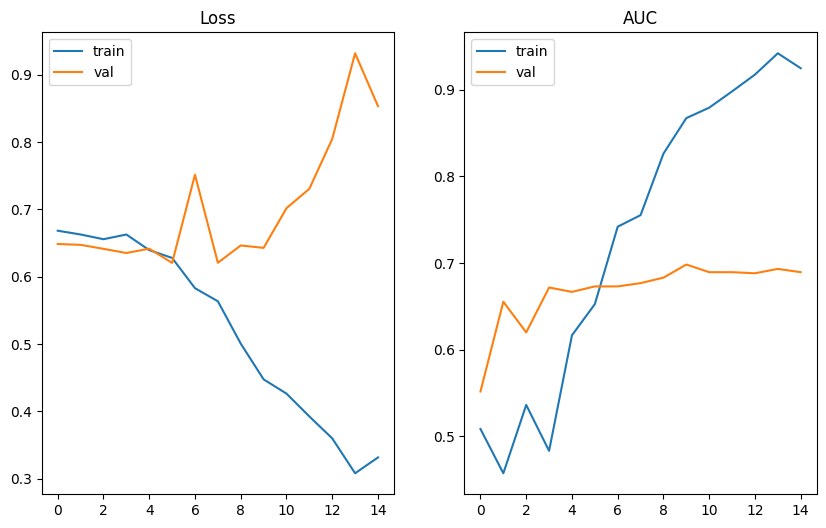


-----------------------------Finished in 0:00:35.554743---------------------------------------

Running cross-validation on split #2


100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


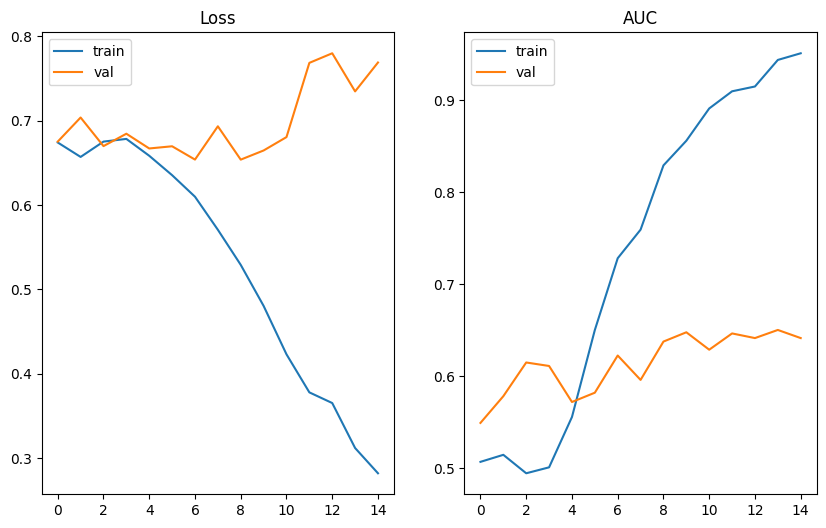


-----------------------------Finished in 0:00:31.901720---------------------------------------

Running cross-validation on split #3


100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


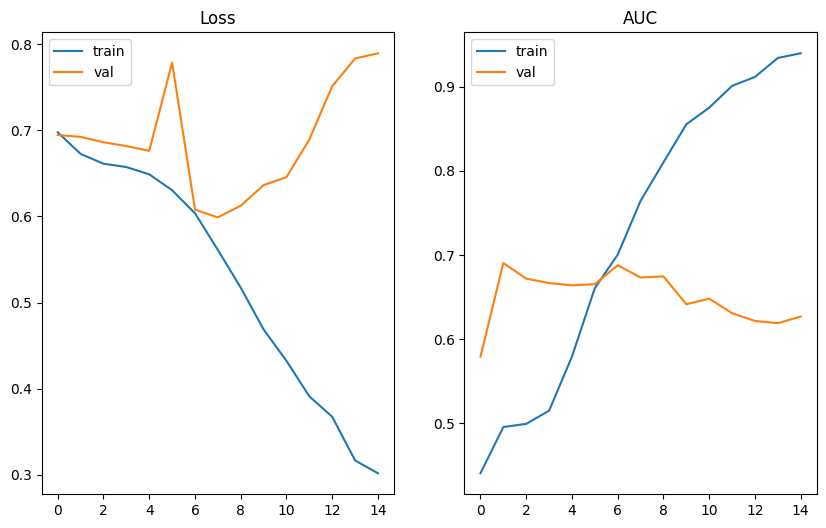


-----------------------------Finished in 0:00:31.213338---------------------------------------

Running cross-validation on split #4


100%|██████████| 15/15 [00:30<00:00,  2.01s/it]


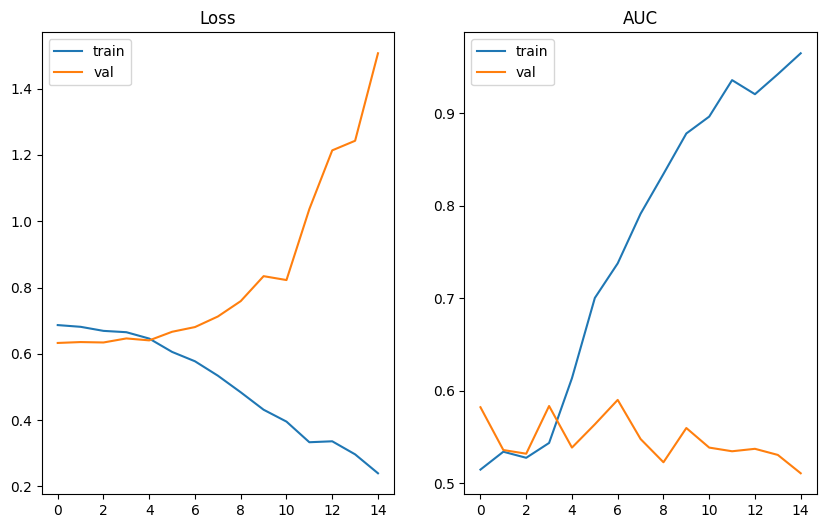


-----------------------------Finished in 0:00:30.956151---------------------------------------

Running cross-validation on split #5


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


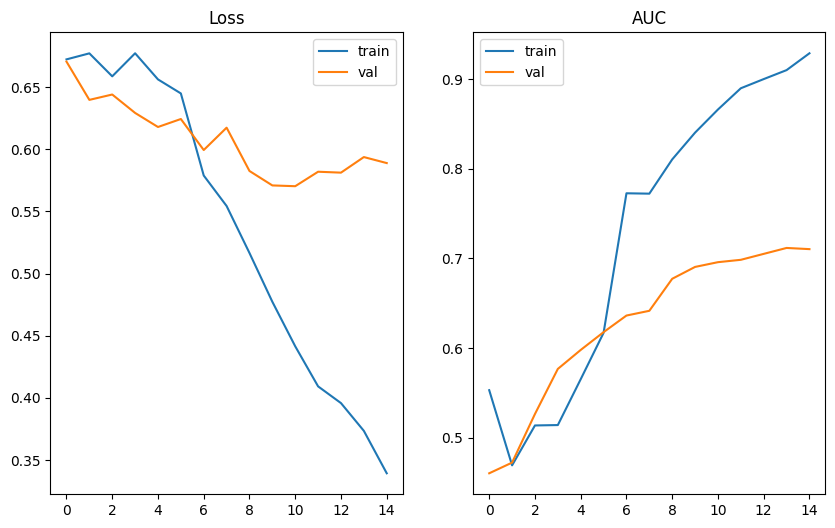


-----------------------------Finished in 0:00:31.557664---------------------------------------

Running cross-validation on split #6


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


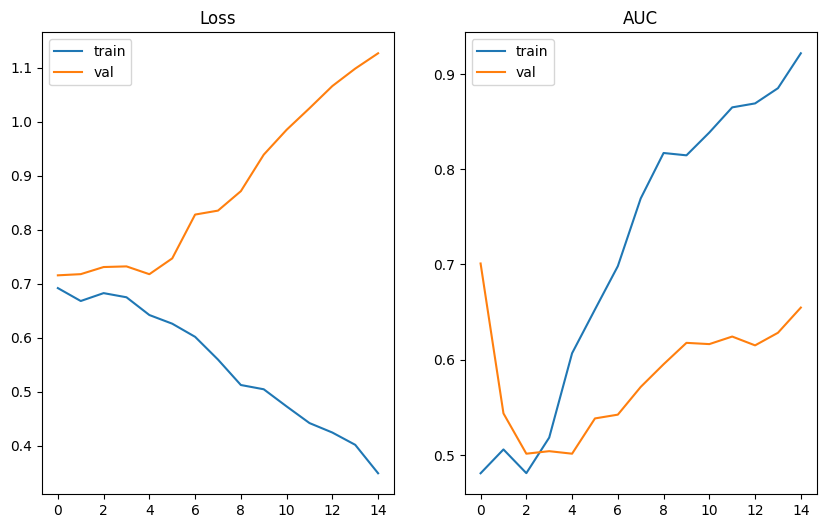


-----------------------------Finished in 0:00:31.730334---------------------------------------


Finished cross-validation in 0:03:14.353897


In [35]:
# We run a 5-fold cross-validation with 1 repeat (you can tweak these parameters)
n_repeats = 1
n_folds = 6
train_metrics, val_metrics = [], []
train_losses, val_losses = [], []
test_logits = []

cv_start_time = datetime.now()

for repeat in range(n_repeats):
    print(f"Running cross-validation #{repeat+1}")
    # We stratify with respect to the training labels
    cv_skfold = StratifiedKFold(
        n_splits=n_folds,
        shuffle=True,
        random_state=repeat,
    )
    cv_splits = cv_skfold.split(train_indices, y = train_labels)

    # 1 training fold approximately takes 25 seconds
    for i, (train_indices_, val_indices_) in enumerate(cv_splits):
        fold_start_time = datetime.now()
        trainer = TorchTrainer(
            model=deepcopy(chowder),
            criterion=criterion,
            metrics=metrics,
            batch_size=8,                           # you can tweak this
            num_epochs=15,                           # you can tweak this
            learning_rate=1e-3,                      # you can tweak this
            weight_decay=0,                        # you can tweak this
            device="cuda:0",
            optimizer=deepcopy(optimizer),
            train_step=slide_level_train_step,
            val_step=slide_level_val_step,
            collator=pad_collate_fn,
            use_tqdm=True,
        )

        print(f"Running cross-validation on split #{i+1}")
        train_dataset_ = torch.utils.data.Subset(
            train_dataset, indices=train_indices_
        )
        val_dataset_ = torch.utils.data.Subset(
            train_dataset, indices=val_indices_
        )

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            # Training step for the given number of epochs
            local_train_metrics, local_val_metrics = trainer.train(
                train_dataset_, val_dataset_
            )
            # Predictions on test (logits, sigmoid(logits) = probability)
            local_test_logits = trainer.predict(test_dataset)[1]

        train_losses.append(trainer.train_losses)
        val_losses.append(trainer.val_losses)
        train_metrics.append(local_train_metrics)
        val_metrics.append(local_val_metrics)
        test_logits.append(local_test_logits)
        fold_end_time = datetime.now()
        fold_running_time = fold_end_time - fold_start_time
        
        ## Plot the training and validation loss || and training and validation AUC (2 columns)
        fig, axs = plt.subplots(1, 2, figsize=(10, 6))
        axs[0].plot(trainer.train_losses, label="train")
        axs[0].plot(trainer.val_losses, label="val")
        axs[0].set_title("Loss")
        axs[0].legend()
        axs[1].plot(local_train_metrics["auc"], label="train")
        axs[1].plot(local_val_metrics["auc"], label="val")
        axs[1].set_title("AUC")
        axs[1].legend()
        plt.show()    
        
        
        print("\n-----------------------------Finished in {}---------------------------------------\n".format(fold_running_time))
    #clear_output()
cv_end_time = datetime.now()
cv_running_time = cv_end_time - cv_start_time
print("\nFinished cross-validation in {}".format(cv_running_time))

In [36]:
## Plot the 
len(train_metrics), len(val_metrics), len(test_logits)

(6, 6, 6)

In [37]:
len(train_metrics[0]['auc'])

15

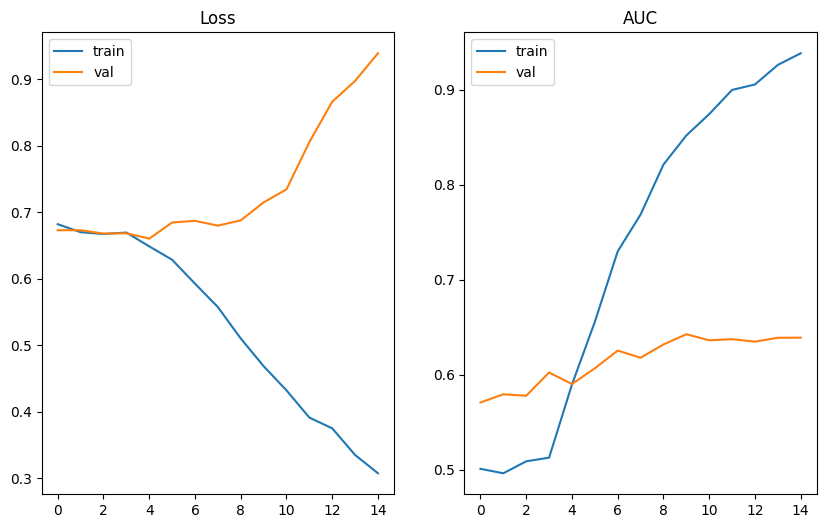

In [38]:
## Plot the global training and validation loss || and training and validation AUC (2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].plot(np.mean(train_losses, axis=0), label="train")
axs[0].plot(np.mean(val_losses, axis=0), label="val")
axs[0].set_title("Loss")
axs[0].legend()
axs[1].plot(np.mean([m["auc"] for m in train_metrics], axis=0), label="train")
axs[1].plot(np.mean([m["auc"] for m in val_metrics], axis=0), label="val")
axs[1].set_title("AUC")
axs[1].legend()
plt.show()


In [40]:
test_probas = [sigmoid(logits) for logits in test_logits]
test_probas = np.array(test_probas).mean(axis=0).squeeze()
print(test_probas.shape)
print(min(test_probas), max(test_probas))

(149,)
0.009470757 0.84104013


In [41]:
test_metadata_df["Sample ID"].shape

(149,)

In [42]:
submission = pd.DataFrame(
    {"Sample ID": test_metadata_df["Sample ID"].values, "Target": test_probas}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"


In [43]:
# save the submission as a csv file
submission.to_csv("benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.257875
1,ID_004.npy,0.723291
2,ID_008.npy,0.327763
3,ID_009.npy,0.491531
4,ID_010.npy,0.134630
